In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy import signal as sig
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("data.csv")
phase_scan = pd.read_csv("dc.csv")
heating_voltage = phase_scan["Heating"].to_numpy().T
detector_1 = phase_scan["Detector 1"].to_numpy().T
detector_2 = phase_scan["Detector 2"].to_numpy().T
detector_3 = phase_scan["Detector 3"].to_numpy().T

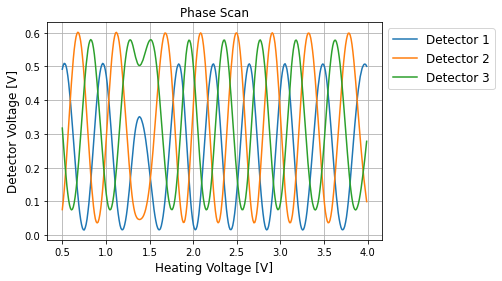

In [3]:
plt.plot(heating_voltage, detector_1, label="Detector 1")
plt.plot(heating_voltage, detector_2, label="Detector 2")
plt.plot(heating_voltage, detector_3, label="Detector 3")
plt.xlabel("Heating Voltage [V]", fontsize=12)
plt.ylabel("Detector Voltage [V]", fontsize=12)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.grid(True)
plt.title("Phase Scan", fontsize=12)
plt.show()

In [4]:
def scale_data(data):
    return 2 * (data - min(data)) / (max(data) - min(data)) - 1

In [5]:
dc_scaled = [scale_data(detector_1), scale_data(detector_2), scale_data(detector_3)]

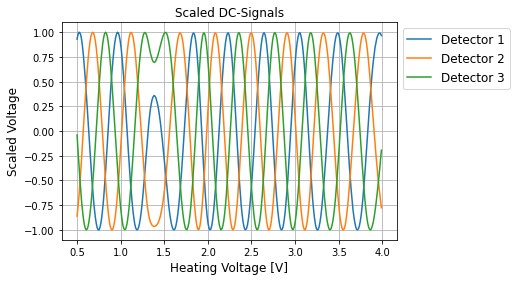

In [6]:
plt.plot(heating_voltage, dc_scaled[0], label="Detector 1")
plt.plot(heating_voltage, dc_scaled[1], label="Detector 2")
plt.plot(heating_voltage, dc_scaled[2], label="Detector 3")
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.grid(True)
plt.xlabel("Heating Voltage [V]", fontsize=12)
plt.ylabel("Scaled Voltage", fontsize=12)
plt.title("Scaled DC-Signals", fontsize=12)
plt.show()

In [7]:
def ellipse(z):
    x = []
    y = []
    for i in range(len(dc_scaled[0])):
        i_0 = dc_scaled[0][i]
        i_1 = dc_scaled[1][i]
        i_2 = dc_scaled[2][i]
        x.append(i_0 + i_1 * np.cos(z[0]) + i_2 * np.cos(z[1]))
        y.append(i_1 * np.sin(z[0]) + i_2 * np.sin(z[1]))
    x, y = np.array(x), np.array(y)
    return x, y

In [8]:
def standard_deviation_circle(z):
  x, y = ellipse(z)
  return np.var(x ** 2 + y ** 2)

In [9]:
res = optimize.minimize(standard_deviation_circle, x0=np.array([2 * np.pi / 3, 4 * np.pi / 3]))
x, y = ellipse(res.x)
phi_d = [0, res.x[0], res.x[1]]

Difference max x and y: x = 0.0012996122984303415         
Difference min x and y: x = 0.003573870831305337
Correction phases are 113.23576124450129° and 232.98259592766456°


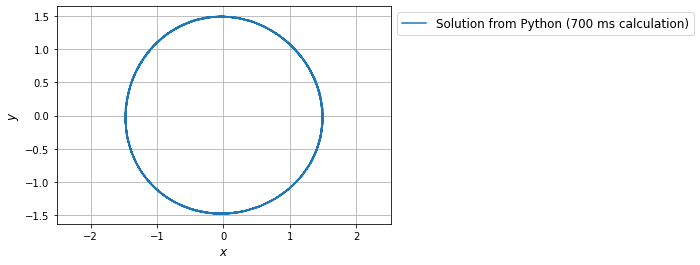

In [10]:
print(f"Difference max x and y: x = {abs(max(x) - max(y))} \
        \nDifference min x and y: x = {abs(min(x) - min(y))}")
print(f"Correction phases are {res.x[0] / np.pi * 180}° and {res.x[1] / np.pi * 180}°")
plt.plot(x, y, label="Solution from Python (700 ms calculation)")
plt.grid(True)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.axis("equal")
plt.show()

In [11]:
def low_pass(measurement, fs, order, fc):
    nyq = 0.5 * fs 
    cut = fc / nyq
    lp_b, lp_a = sig.butter(order, cut, btype='lowpass')  # Design and apply the low-pass filter.
    lp_data = list(sig.filtfilt(lp_b, lp_a, measurement))  # Apply forward-backward filter with linear phase.
    return lp_data

In [12]:
phi = []
system_phase = []
for j in range(1, 4):
    X = data[f"Norm D{j}X"][700:900]
    Y = data[f"Norm D{j}Y"][700:900]
    system_phase.append(np.mean(np.arctan2(Y, X)))
print(np.array(system_phase) / np.pi * 180)
system_phase[0] = system_phase[0] - np.pi
phases = []
dc_scaled = [data["Norm DC1 (V)"], data["Norm DC2 (V)"], data["Norm DC3 (V)"]]
for i in range(len(dc_scaled[0])):
    delta_phi = []
    weight = []
    x = dc_scaled[0][i] + dc_scaled[1][i] * np.cos(phi_d[1]) + dc_scaled[2][i] * np.cos(phi_d[2])
    y = dc_scaled[1][i] * np.sin(phi_d[1]) + dc_scaled[2][i] * np.sin(phi_d[2])
    signal_phase = np.arctan2(y, x)
    for j in range(1, 4):
        X = data[f"Norm D{j}X"][i]
        Y = data[f"Norm D{j}Y"][i]
        R = 1 / 2 * np.sqrt(X ** 2 + Y ** 2)
        theta = np.arctan2(Y, X)
        dms = R * np.cos(theta - system_phase[j - 1])
        phases.append(theta)
        delta_phi.append(dms / -np.sin(signal_phase - phi_d[j - 1]))
        weight.append(np.abs(-np.sin(signal_phase - phi_d[j - 1])))
    delta_phi = np.array(delta_phi)
    weight = np.array(weight)
    phi.append(np.abs(np.sum(delta_phi * weight) / np.sum(weight)))

[130.47714221 -50.01057688 -49.22731785]


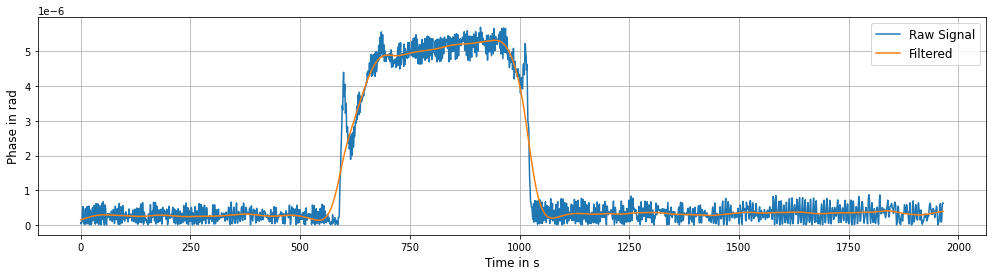

In [13]:
figure = plt.figure()
figure.set_figwidth(17)
plt.plot(range(len(phi)), phi, label="Raw Signal")
plt.plot(range(len(phi)), low_pass(phi, fs=1, order=2, fc=1e-2), label="Filtered")
plt.grid(True)
plt.xlabel("Time in s", fontsize=12)
plt.ylabel("Phase in rad", fontsize=12)
plt.legend(fontsize=12)
plt.savefig("plot.pdf")
plt.show()

In [14]:
with open("phases.csv", "w") as f:
  f.write("Phase in rad\n")
  for phase in phi:
    f.write(f"{phase}\n")